# NTDS'18 milestone 1: network collection and properties
[Effrosyni Simou](https://lts4.epfl.ch/simou), [EPFL LTS4](https://lts4.epfl.ch)

### Students

* Team: `30`
* Students: `Tim Tuuva, Lucas Biotto, Anael Buchegger,Joachim Tapparel`
* Dataset: `Free Music Archive`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to three sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective 

The purpose of this milestone is to start getting acquainted to the network that you will use for this class. In the first part of the milestone you will import your data using [Pandas](http://pandas.pydata.org) and you will create the adjacency matrix using [Numpy](http://www.numpy.org). This part is project specific. In the second part you will have to compute some basic properties of your network. **For the computation of the properties you are only allowed to use the packages that have been imported in the cell below.** You are not allowed to use any graph-specific toolboxes for this milestone (such as networkx and PyGSP). Furthermore, the aim is not to blindly compute the network properties, but to also start to think about what kind of network you will be working with this semester. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [2]:
plt.rcParams['figure.figsize'] = [10, 7]

## Part 1 - Import your data and manipulate them. 

###  A. Load your data in a Panda dataframe.

First, you should define and understand what are your nodes, what features you have and what are your labels. Please provide below a Panda dataframe where each row corresponds to a node with its features and labels. For example, in the the case of the Free Music Archive (FMA) Project, each row of the dataframe would be of the following form:


| Track   |  Feature 1  | Feature 2 | . . . | Feature 518|  Label 1 |  Label 2 |. . .|Label 16|
|:-------:|:-----------:|:---------:|:-----:|:----------:|:--------:|:--------:|:---:|:------:|
|         |             |           |       |            |          |          |     |        |

It is possible that in some of the projects either the features or the labels are not available. This is OK, in that case just make sure that you create a dataframe where each of the rows corresponds to a node and its associated features or labels.

In [3]:
tracks = pd.read_csv('../data/fma_metadata/tracks.csv', index_col=0, header=[0, 1]);
features= pd.read_csv('../data/fma_metadata/features.csv', index_col=0, header=[0, 1, 2])
#genres=pd.read_csv('../data/fma_metadata/genres.csv',sep=',', encoding='utf-8', engine='python');
#echonest=pd.read_csv('../data/fma_metadata/echonest.csv',sep=',', encoding='utf-8', engine='python');

In [4]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top']})

# Keep on the tracks from small subset
label = label[tracks['set','subset'] == 'small']

# Keep only the Hip-Hop/Rock
genre_list = ['Hip-Hop', 'Rock']
label = label[label['label']['genre']['main'].isin(genre_list)]

# Merging
dataSetSmall = features.merge(label, left_index=True, right_on='track_id')
dataSetSmall=dataSetSmall.sort_values([('label', 'genre','main')])

In [5]:
# data set in right form
dataSetSmall.head(5)

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
97697        -0.418234 -0.262583 -0.943153 -0.507000 -0.649538 -0.906905   
97692        -0.489030 -0.250322 -0.433721 -0.862085 -0.654477 -1.163852   
97691        -0.612269 -0.976245 -0.934341 -1.417804 -1.144153 -0.661156   
97570        -0.054822 -0.385341 -0.533920 -0.111077 -0.390615 -0.862268   

feature                                              ...      tonnetz  \
statistics                                           ...          std   
number            07        08        09        10   ...           05   
track_id                                             ...                
2           1.481593  2.691455  0.866868  1.341231   ...     0.012226   
97697      -0.775620 -0.640436 -0.359706 -0.824896   ...     0.015472   
97692      -0.279070 -0.703046 -0.158406 -0.281246   ...     0.025265   
97691      -1.399781 -1.188278 -1.259354 -1.363564   ...     0.021943   
97570      -0.487813 -0.278844  0.358889 -0.930209   ...     0.015522   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
97697       0.026933   6.853233  0.818848  0.088408  0.030762  0.000000   
97692       0.022538  15.887112  0.751465  0.048796  0.015625  0.001465   
97691       0.024145  26.944431  0.816895  0.045936  0.018555  0.001953   
97570       0.022561   7.659225  0.267578  0.031552  0.025391  0.001953   

feature                           label  
statistics      skew       std    genre  
number            01        01     main  
track_id                                 
2           2.089872  0.061448  Hip-Hop  
97697       2.853373  0.165757  Hip-Hop  
97692       4.025317  0.114844  Hip-Hop  
97691       5.193826  0.108769  Hip-Hop  
97570       2.117155  0.023941  Hip-Hop  

[5 rows x 519 columns]

In [6]:
dataSetSmall.shape #we get as expected a subset of 2000 tracks with 518 features and one label (Rock or Hip-hop)

(2000, 519)

### B. Create the adjacency matrix of your network.

Remember that there are edges connecting the attributed nodes that you organized in the dataframe above. The connectivity of the network is captured by the adjacency matrix $W$. If $N$ is the number of nodes, the adjacency matrix is an $N \times N$ matrix where the value of $W(i,j)$ is the weight of the edge connecting node $i$ to node $j$.  

There are two possible scenarios for your adjacency matrix construction, as you already learned in the tutorial by Benjamin:

1) The edges are given to you explicitly. In this case you should simply load the file containing the edge information and parse it in order to create your adjacency matrix. See how to do that in the  [graph from edge list]() demo.

2) The edges are not given to you. In that case you will have to create a feature graph. In order to do that you will have to chose a distance that will quantify how similar two nodes are based on the values in their corresponding feature vectors. In the [graph from features]() demo Benjamin showed you how to build feature graphs when using Euclidean distances between feature vectors. Be curious and explore other distances as well! For instance, in the case of high-dimensional feature vectors, you might want to consider using the cosine distance. Once you compute the distances between your nodes you will have a fully connected network. Do not forget to sparsify by keeping the most important edges in your network.

Follow the appropriate steps for the construction of the adjacency matrix of your network and provide it in the Numpy array ``adjacency`` below: 

In [7]:
#we calculate the distances of our dataset
distances = pdist(dataSetSmall.drop(columns='label',level=0).values, metric='cosine')

In [8]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)

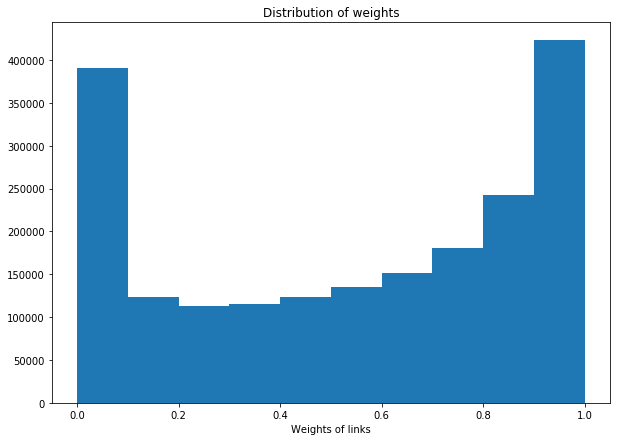

In [9]:
plt.hist(weights)
plt.title('Distribution of weights')
plt.xlabel('Weights of links')
plt.show()

In [10]:
#We only keep the strongest links
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.95] = 0
n_nodes = dataSetSmall.shape[0]

**The cosine metric and the value required to keep links in the adjacency matrix of 0.95 were chosen in order to get a good distinction between rock and hip-hop when using gephi**

The following image show the result using the spacialisation force atlas II (red:=rock, green:=hip-hop)

 to do song id 110779 hip-hop and 3833 rock and 9559 hip-rock 36987 top right 105142 bottom left
 By listening to tracks from differents extremes of the graph, we can clearly hear very different musical properties.(for instance: 110779 hip-hop, 3833 rock, 9559 'hip-rock', 36987 top right, 105142 bottom left)

In [11]:
#from IPython.display import Image
#Image("../data/cos_95.png",width=500)

## Part 2

Execute the cell below to plot the (weighted) adjacency matrix of your network.

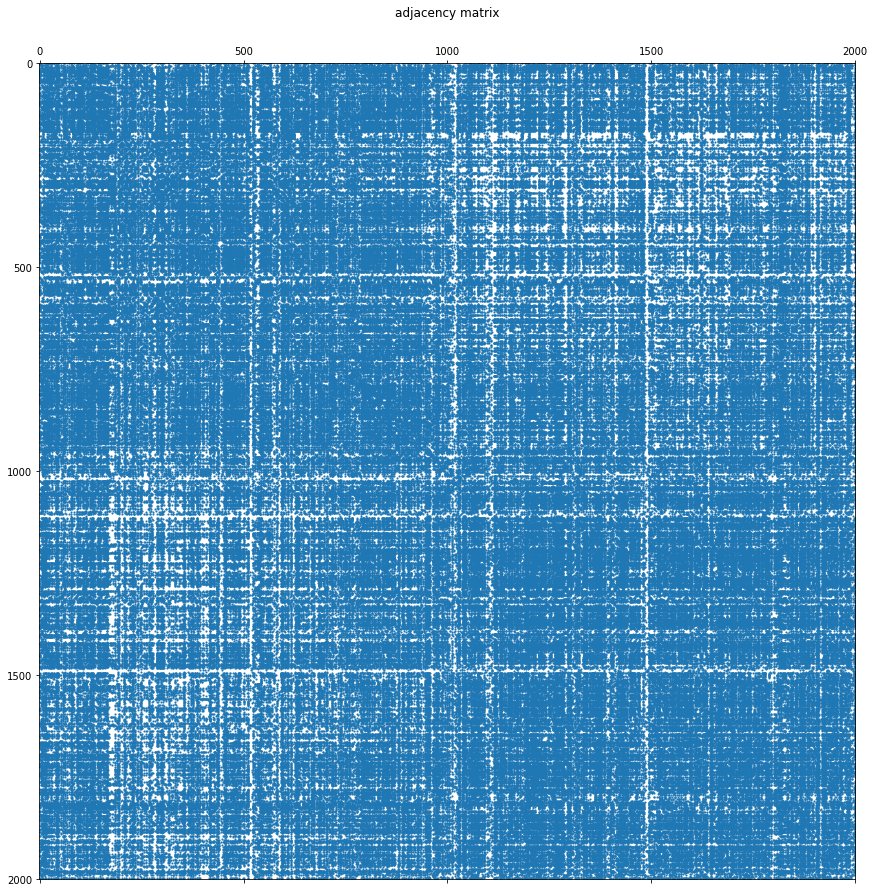

In [12]:
plt.figure(figsize=(15, 15))
plt.spy(adjacency, markersize=1)
plt.title('adjacency matrix')
plt.show()

### Question 1

What is the maximum number of links $L_{max}$ in a network with $N$ nodes (where $N$ is the number of nodes in your network)? How many links $L$ are there in your collected network? Comment on the sparsity of your network.

In [13]:
L=(sum(sum(np.ceil(adjacency))))/2
L_max=n_nodes*(n_nodes-1)/2
print("L=", L, "\nL_max=", L_max, "\nSparsity ratio=", L/L_max)

L= 250493.0 
L_max= 1999000.0 
Sparsity ratio= 0.12530915457728864


**The sparsity of our network depends both on the minimal link weight and on the type of norm that is used. With those two parameters, we can make the sparsity vary as we want**

With the parameter that we choosed, our network isn't very sparse with more than ten percent of links existing.

### Question 2

Is your graph directed or undirected? If it is directed, convert it to an undirected graph by symmetrizing the adjacency matrix.

**Since we use distances between nodes and $||N_i-N_j||_{cosine}=||N_j-N_i||_{cosine}$ our graph is undirected. We can verify that our adjacency matrix is symmetric using the following code:**

In [14]:
print("Is adjacency matrix symmetric ?:", np.allclose(adjacency, adjacency.T))
print('Our graph is as expected undirected')

Is adjacency matrix symmetric ?: True
Our graph is as expected undirected


### Question 3

In the cell below save the features dataframe and the **symmetrized** adjacency matrix. You can use the Pandas ``to_csv`` to save the ``features`` and Numpy's ``save`` to save the ``adjacency``. We will reuse those in the following milestones.

In [15]:
dataSetSmall.to_csv('../data/fma_metadata/dataSetSmall.csv',encoding='utf-8', index=True)
np.save('../data/fma_metadata/adjacency.npy',adjacency)

### Question 4

Are the edges of your graph weighted?

**Yes, each edge has a weight between 0 and 1, as it can be seen in the adjacency matrix.**

We will only keep the weights between 0.95 and 1 (matrix 'adjacency')

In [16]:
adjacency_full

array([[0.        , 0.13738248, 0.01593795, ..., 0.97130292, 0.81740224,
        0.87536886],
       [0.13738248, 0.        , 0.97840825, ..., 0.02665978, 0.04397016,
        0.52294388],
       [0.01593795, 0.97840825, 0.        , ..., 0.00107399, 0.00691476,
        0.34417289],
       ...,
       [0.97130292, 0.02665978, 0.00107399, ..., 0.        , 0.63977129,
        0.50675151],
       [0.81740224, 0.04397016, 0.00691476, ..., 0.63977129, 0.        ,
        0.74044965],
       [0.87536886, 0.52294388, 0.34417289, ..., 0.50675151, 0.74044965,
        0.        ]])

### Question 5

What is the degree distibution of your network? 

In [17]:
degree =sum(np.ceil(adjacency))

assert len(degree) == n_nodes

Execute the cell below to see the histogram of the degree distribution.

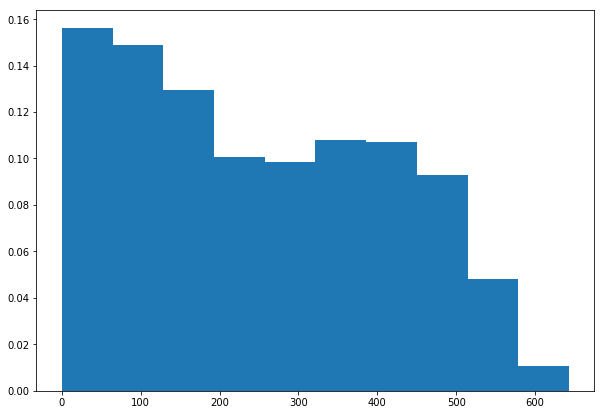

In [18]:
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

What is the average degree?

In [19]:
print('Average degree =',sum(sum(adjacency))/n_nodes)

Average degree = 244.58888240440749


### Question 6

Comment on the degree distribution of your network.

**No node has more than 600 links (with our distance calculation and threshold), indicating that there aren't any hubs. The curve tends to show that nodes with few connections are more frequent.**

### Question 7

Write a function that takes as input the adjacency matrix of a graph and determines whether the graph is connected or not.

In [20]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """   
    
    adjacency=np.array(adjacency);
    
    alreadyDone=[]; #point already visited
    notDone=list(range(1,adjacency.shape[0])); #list keeping track of the nodes to explore
    toCheck=[0] #temporary list of nodes to process 
    
    #search every connected node 
    while toCheck:
        node=toCheck.pop(0);
        if node not in alreadyDone:
            alreadyDone.append(node);
            for j in notDone: #we search every connected node that hasn't already been processed
                if adjacency[node][j] :
                    toCheck.append(j)
                    notDone.remove(j)
    #check if all nodes have been visited
    if len(alreadyDone)<adjacency.shape[0]:
        connected=False;
    else:
        connected=True;
    return connected

Is your graph connected? Run the ``connected_graph`` function to determine your answer.

In [21]:
# Your code here.
print("Is our graph connected?",connected_graph(adjacency))

Is our graph connected? False


### Question 8

Write a function that extracts the connected components of a graph.

In [22]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """        
    adjacency=np.array(adjacency);
    components=[]; # list of components and the nodes included in them
    adj_components=[];  #list of adjacency matrix for each component 
    compoNodes=[]; #nodes of a component
    alreadyDone=[]; #nodes already vsited
    
    notDone=list(range(1,adjacency.shape[0])); # node still not visited (this list is the inverse alreadyDone
                                               # but having both of them speed up the execution of the algorithm)
    toCheck=[0] #nodes that have a parent in the component
    while toCheck:
        node=toCheck.pop(0); #new active node
        if node not in alreadyDone: #
            alreadyDone.append(node);
            compoNodes.append(node);
            for j in notDone: #we search every connected node that hasn't already been processed
                if adjacency[node][j]:
                    toCheck.append(j);
                    notDone.remove(j);
                    
        #new component in case that all nodes haven't been visited and previous component has been done
        if not toCheck and len(alreadyDone)<adjacency.shape[0]:
            toCheck.append(notDone[0])
            components.append(compoNodes);
            compoNodes=[]
            notDone.remove(notDone[0])
    components.append(compoNodes); # add the last component to the list
    
    components=sorted(np.array(components),key=len,reverse=True)#sort the component by size  
    
    for i in range(0,len(components)): #construct the adjacency matrix for each component
        adj_temp=np.zeros(adjacency.shape)
        for j in components[i]:
            adj_temp[j][:]=adjacency[j][:];
            adj_temp[:][j]=adjacency[:][j];
        adj_components.append(np.asarray(adj_temp));
    
    #return the 2000x2000 adjacency matrices sorted by component size (biggest first)
    #We keep 2000x2000 matrices to keep track of the indices, even if by doing that we virtualy create isolated nodes
    #for each node that isn't in the component.
    return adj_components

How many connected components is your network composed of? What is the size of the largest connected component? Run the ``find_components`` function to determine your answer. 

In [23]:
comp=find_components(adjacency)
print('Number of components:',len(comp))
max_comp=np.count_nonzero(np.count_nonzero(comp[0],axis=1));
print('Largest component count:', max_comp,'nodes')

Number of components: 13
Largest component count: 1988 nodes


### Question 9

Write a function that takes as input the adjacency matrix and a node (`source`) and returns the length of the shortest path between that node and all nodes in the graph using Dijkstra's algorithm. **For the purposes of this assignment we are interested in the hop distance between nodes, not in the sum of weights. **

Hint: You might want to mask the adjacency matrix in the function ``compute_shortest_path_lengths`` in order to make sure you obtain a binary adjacency matrix. 

In [24]:
def compute_shortest_path_lengths(adjacency, source):
    """Compute the shortest path length between a source node and all nodes.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    
    Returns
    -------
    list of ints
        The length of the shortest path from source to all nodes. Returned list should be of length n_nodes.
    """
    #converting to binary adjacency matrix
    adjacency=np.ceil(adjacency)
    
    #create labels list
    shortest_path_lengths = np.full(adjacency.shape[0],np.inf)
    shortest_path_lengths[source]=0
    
    #initialization
    nodelist = []
    n = 1;
    notDone=list(range(1,adjacency.shape[0])) #used to avoid useless loops
    start = True

    while start or len(nodelist):
  
        if start == False:
            #the new source is the first label
            notDone.remove(nodelist[0])
            #drop first node (source)
            source = nodelist.pop(0)   
        start = False

        #going through the line in the adjacency matrix, labelling every new length
        for i in notDone:
            if adjacency[source][i] and shortest_path_lengths[i] == np.inf:
                shortest_path_lengths[i] = n
                nodelist.append(i)                     
        n+= 1

    return shortest_path_lengths

### Question 10

The diameter of the graph is the length of the longest shortest path between any pair of nodes. Use the above developed function to compute the diameter of the graph (or the diameter of the largest connected component of the graph if the graph is not connected). If your graph (or largest connected component) is very large, computing the diameter will take very long. In that case downsample your graph so that it has 1.000 nodes. There are many ways to reduce the size of a graph. For the purposes of this milestone you can chose to randomly select 1.000 nodes. 

In [ ]:
max=0;
node=np.random.choice(range(0,comp[0].shape[0]),1000,replace=False) #comp[0] is our biggest component
for i in node:
    path=compute_shortest_path_lengths(comp[0],i);
    path_max=path[path <adjacency.shape[0]].max(); 
    if path_max > max:
        max=path_max 
print('The diameter of our largest component is:',max) 

We tried many times with smaller samples and always end up with about 1980 as
there will always be at least one node that is far away for every node.

### Question 11

Write a function that takes as input the adjacency matrix, a path length, and two nodes (`source` and `target`), and returns the number of paths of the given length between them.

In [ ]:
def compute_paths(adjacency, source, target, length):
    """Compute the number of paths of a given length between a source and target node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    source: int
        The source node. A number between 0 and n_nodes-1.
    target: int
        The target node. A number between 0 and n_nodes-1.
    length: int
        The path length to be considered.
    
    Returns
    -------
    int
        The number of paths.
    """
    adjacency=np.ceil(adjacency);
    #Based on a graph theory theorem
    n_paths=np.linalg.matrix_power(adjacency,length)[source][target]
    return n_paths

Test your function on 5 pairs of nodes, with different lengths.

In [ ]:
print(compute_paths(adjacency, 0, 10, 1))
print(compute_paths(adjacency, 0, 10, 2))
print(compute_paths(adjacency, 0, 10, 3))
print(compute_paths(adjacency, 23, 67, 2))
print(compute_paths(adjacency, 15, 93, 4))

We observe that the possibilities explode as the path length increases 

### Question 12

How many paths of length 3 are there in your graph? Hint: calling the `compute_paths` function on every pair of node is not an efficient way to do it.

In [ ]:
print("There are",int(sum(sum(np.linalg.matrix_power(np.ceil(adjacency),3)))),'paths.')

### Question 13

Write a function that takes as input the adjacency matrix of your graph (or of the largest connected component of your graph) and a node and returns the clustering coefficient of that node. 

In [ ]:
def compute_clustering_coefficient(adjacency, node):
    """Compute the clustering coefficient of a node.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    node: int
        The node whose clustering coefficient will be computed. A number between 0 and n_nodes-1.
    
    Returns
    -------
    float
        The clustering coefficient of the node. A number between 0 and 1.
    """
    #initialization
    adjacency=np.array(adjacency);
    neighbors = []
    doubleLi = 0;
    ki=0;
    clustering_coefficient=0;
    
    
    for i in range(adjacency.shape[0]): #get all the neighbours of the node
        if adjacency[node][i]:
            neighbors.append(i);            
    ki = len(neighbors)
    
    for j in neighbors: #counting all the links between the neighbours(twice)
        for k in neighbors:
            if adjacency[j][k]:
                doubleLi+=1;
    #applying the formula        
    if ki > 1:
        clustering_coefficient = doubleLi/(ki*(ki-1));       
    return clustering_coefficient

### Question 14

What is the average clustering coefficient of your graph (or of the largest connected component of your graph if your graph is disconnected)? Use the function ``compute_clustering_coefficient`` to determine your answer.

In [ ]:
all_clustering_coefficient = []

for i in range(comp[0].shape[0]): # comp[0] is our largest connected component
    all_clustering_coefficient.append(compute_clustering_coefficient(comp[0], i));

avg_clustering_coefficient = sum(all_clustering_coefficient)/max_comp;#max_comp is the size of our main component

print('Our average clustering coefficient is:',avg_clustering_coefficient)